<a href="https://colab.research.google.com/github/morganmcg1/control-ui/blob/main/Copy_of_Fine_tune_Donut_on_UI_RefExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Donut 🍩 on UI RefExp

> _NOTE_: This notebook is based on the [Donut fine-tuning notebooks by Niels Rogge](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/Donut). 

In this notebook, we'll fine-tune [Donut](https://huggingface.co/docs/transformers/model_doc/donut) (which is an instance of [`VisionEncoderDecoderModel`](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)) on a [UI RefExp dataset](https://huggingface.co/datasets/ivelin/ui_refexp_saved), which is a dataset consisting of triplets: (UI screenshot, prompt, and target bounding box). This way, the model will learn to look at a screenshot image, and answer a prompt referring to a UI component. For example: "select the search icon next to the menu drawer". This could be useful for tasks such as converting natural language app documentation to exectuable tests, bug reporting front end test automation and app support chat bots.

Multiple specialized models have been proposed to solve the UI RefExp task in recent years: [seq2act](https://paperswithcode.com/paper/mapping-natural-language-instructions-to), [UIBert](https://paperswithcode.com/paper/uibert-learning-generic-multimodal), [pix2struct](https://paperswithcode.com/paper/pix2struct-screenshot-parsing-as-pretraining) and others.

Here we will use Donut - an OCR-free Document Understanding model with state of the art performance as of 2022. Donut showed SOTA performance across several natural languages and document understanding tasks. Since UI components use language labels as well as image icons such Material Design and emoticons, we hope that it's ability to extract features from multiple languages will transfer to non-textual UI component features.

Let's find out if Donut can be fine tuned to perform well on the UI RefExp task even though it was not originally designed for it. The intuition is that paper documents have similar visual and language comprehension challenges as UI screens. Since Donut is OCR-free multi-modal model, it should be able to pick up visual and text features in UI components as well as spacial relationships between them.

In [Grounding Natural Language Instructions: Can Large Language Models Capture Spatial Information?](https://arxiv.org/abs/2109.08634) it was shown that Document Understanding models such as LayoutLM are able to outperform previous models specialized on UI tasks. However the paper focuses on UI components with text labels. Ideally we would like our model to be able to also understand non-textual components.

We will start from the DocVQA pre-trained Donut model and repurpose the DocVQA fine tuning notebook so that the model learns to output bounding box coordinates of the referred component instead of its text label.

Let's get started!

## Set-up environment

Credit: notebook modified from: https://github.com/ivelin/donut_ui_refexp/tree/main 

First, let's install the relevant libraries:
* 🤗 Transformers, for the model
* 🤗 Datasets, for loading + processing the data
* PyTorch Lightning, for training the model
* Weights and Biases, for logging metrics during training
* Sentencepiece, used for tokenization.

In [1]:
#@title Let's install required dependencies

# !pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/morganmcg1/transformers.git@fix_dec 

In [2]:
# !pip uninstall -y transformers

In [3]:
# !git clone https://github.com/huggingface/transformers.git
# !cd transformers && pip install -e .

In [4]:
!pip install -q datasets sentencepiece

In [5]:
!pip install -q pytorch-lightning wandb

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
#@title Let's see what system resources we are running on
import os
print(f"CPU Count: {os.cpu_count()}")

CPU Count: 12


In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb 12 21:28:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
import torch

def cpu():
    return torch.device('cpu')
def gpu(i=0):
    return torch.device(f'cuda:{i}')
cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [10]:
def num_gpus():
    return torch.cuda.device_count()
num_gpus()

1

In [11]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [12]:
#@title Login to HuggingFace hub so we can save our trained model checkpoints
# !huggingface-cli login

In [13]:
#@title Login to Weights&Biases so we can log and chart our training metrics
!wandb login

wandb: Currently logged in as: morg. Use `wandb login --relogin` to force relogin


## Load dataset

Next, let's load the dataset from the [hub](https://huggingface.co/datasets/ivelin/rico_refexp_combined). We're prepared a RICO based dataset with combined synthetic and crowdsourced UI referring expressions. The first 15K samples in the dataset are crowdsourced. The rest of the 350K samples are synthetically generated.


In [14]:
REFEXP_DATASET_NAME = "ivelin/rico_refexp_combined"

# Pick which pretrained checkpoint to start the fine tuning process from
REFEXP_MODEL_CHECKPOINT = 'ivelin/donut-refexp-combined-v1'

# SMALLER
REFEXP_DATASET_NAME = "ivelin/ui_refexp_saved"

REFEXP_MODEL_CP_BRANCH = 'main' 
# revision: '348ddad8e958d370b7e341acd6050330faa0500f' # Iou = 0.47
# revision: '41210d7c42a22e77711711ec45508a6b63ec380f'# : IoU=0.42 # 
# use 'main' for latest revision

# REFEXP_MODEL_CHECKPOINT = "ivelin/donut-refexp-draft"
# REFEXP_MODEL_CHECKPOINT = "naver-clova-ix/donut-base"
# REFEXP_MODEL_CHECKPOINT = "ivelin/donut-docvqa-demo"

In [15]:
from datasets import load_dataset

dataset = load_dataset(REFEXP_DATASET_NAME, num_proc=10)

Using custom data configuration ivelin--ui_refexp_saved-6916d19d5dad9975
Found cached dataset parquet (/home/jupyter/.cache/huggingface/datasets/ivelin___parquet/ivelin--ui_refexp_saved-6916d19d5dad9975/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

As can be seen, the dataset contains a training, a validation and a test split. And each example consists of an image, a prompt, and a target bounding box.

In [16]:
print(dataset['train'].info)
print(dataset)

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(decode=True, id=None), 'image_id': Value(dtype='string', id=None), 'image_file_path': Value(dtype='string', id=None), 'prompt': Value(dtype='string', id=None), 'target_bounding_box': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, config_name=None, version=None, splits={'train': SplitInfo(name='train', num_bytes=1911005765, num_examples=15624, shard_lengths=[3906, 3906, 3906, 3906], dataset_name='parquet'), 'validation': SplitInfo(name='validation', num_bytes=60409431, num_examples=471, shard_lengths=None, dataset_name='parquet'), 'test': SplitInfo(name='test', num_bytes=69086257, num_examples=565, shard_lengths=None, dataset_name='parquet')}, download_checksums={'https://huggingface.co/datasets/ivelin/ui_refexp_saved/resolve/38a258997cb5e6dd9b973534d3f860e76a6936a5/data/train-00000-of-00004-2435fd5b921f3ab6.parquet': {'num_bytes

In [17]:
len(dataset["train"])

15624

In [18]:
dataset['train'][49]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=540x960>,
 'image_id': '36017',
 'image_file_path': 'combined/36017.jpg',
 'prompt': 'go to next',
 'target_bounding_box': '{"xmin": 0.8759258985519409, "ymin": 0.03854166716337204, "xmax": 1.0, "ymax": 0.1041666641831398}'}

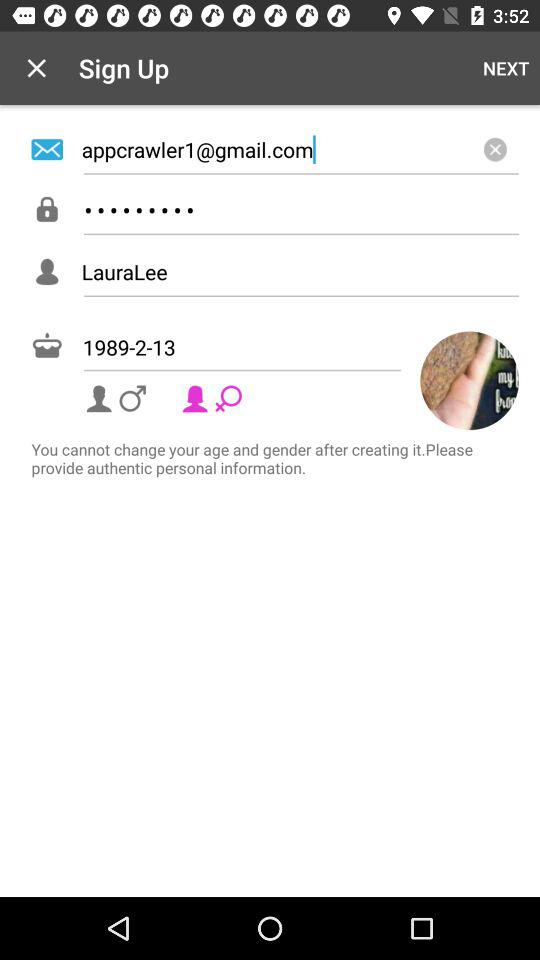

In [19]:
dataset['train'][49]["image"]

image width, height: (540, 960)
prompt: go to next
target bounding box: {'xmin': 0.8759258985519409, 'ymin': 0.03854166716337204, 'xmax': 1.0, 'ymax': 0.1041666641831398}
to image pixel values: xmin, ymin, xmax, ymax: (472, 37, 540, 99)


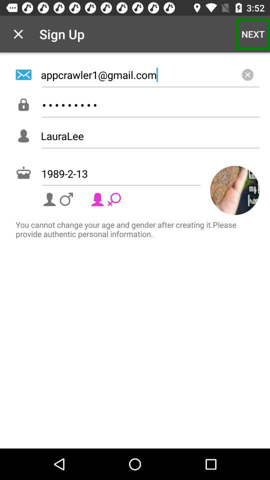

In [20]:
# from tensorflow import string
#@title Let's look at a sample in the dataset
import math
import json
from PIL import Image, ImageDraw

# change this index from 0 to split size to see different samples
sample = dataset['train'][49]
image = sample['image']
width, height = image.size
print(f"image width, height: {width, height}")
print(f"prompt: {sample['prompt']}")

# bb = json.loads(sample["target_bounding_box"])
bb = sample["target_bounding_box"]

if isinstance(bb, str):
  import ast
  bb = ast.literal_eval(bb)

print(f"target bounding box: {bb}")

xmin = math.floor(width*bb["xmin"])
ymin = math.floor(height*bb["ymin"])
xmax = math.floor(width*bb["xmax"])
ymax = math.floor(height*bb["ymax"])

print(f"to image pixel values: xmin, ymin, xmax, ymax: {xmin, ymin, xmax, ymax}")

shape = [(xmin, ymin), (xmax, ymax)]

# create rectangle image
img1 = ImageDraw.Draw(image)  
img1.rectangle(shape, outline ="green", width=5)
image.resize((int(width*0.5), int(height*0.5)))


# Log to WANDB for EDA

In [21]:
# import wandb  
# import ast
# import numpy as np

# cols = ["prompt", "image", "width", "height","xmin", "ymin", "xmax", "ymax"]

# class_id_to_label = {
#     0: "img"
# }

# def get_data(idx):
#   sample = dataset['train'][idx]
#   prompt = sample['prompt']
#   if isinstance(prompt, list): prompt = prompt[0]
#   image = sample['image']
#   if isinstance(image, list): image = image[0]
#   width, height = image.size

#   bb = sample["target_bounding_box"]
#   if isinstance(bb, list): bb = bb[0]
#   if isinstance(bb, str): bb = ast.literal_eval(bb)

#   return image, bb, prompt

# n_imgs = 50
# my_imgs = []

# wandb.init(entity="morg", project="ui_control", job_type='eda')

# for i in range(n_imgs):
#   idx = np.random.randint(0, len(dataset["train"]), 1)

#   image, bb, prompt = get_data(idx)

#   boxes = {
#       "ground_truth": {
#           "box_data" : [{
#             "position": {"minX": bb["xmin"], "maxX": bb["xmax"], "minY": bb["ymin"], "maxY": bb["ymax"]},
#             "class_id": 0,
#             "box_caption": prompt,
#             # "domain": "pixel"
#           }],
#           "class_labels": class_id_to_label
#       }
#   }

#   my_imgs.append(wandb.Image(image, boxes=boxes, caption=f"{idx}_{prompt}"))

#   # tbl = wandb.Table(columns=cols)

# wandb.log({f"bbox_eda": my_imgs})

# wandb.finish()

## Load model and processor

Next, we load the model (which is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder), and the processor, which is the object that can be used to prepare inputs for the model.

In [22]:
from transformers import VisionEncoderDecoderConfig
# from transformers.src.transformers.models.vision_encoder_decoder import VisionEncoderDecoderConfig

pretrained_repo_name = REFEXP_MODEL_CHECKPOINT
pretrained_repo_branch = REFEXP_MODEL_CP_BRANCH

max_length = 128
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained(pretrained_repo_name, branch=pretrained_repo_branch)
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

# Set the decoder_start_token_id
# as per MBART: https://huggingface.co/facebook/mbart-large-50/blob/main/config.json
config.decoder.decoder_start_token_id = 2

In [23]:
# config

In [24]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained(pretrained_repo_name, revision=pretrained_repo_branch)
model = VisionEncoderDecoderModel.from_pretrained(pretrained_repo_name, revision=pretrained_repo_branch, config=config)

## Add special tokens

For RefExp, we add special tokens for \<prompt> \<target_bounding_box>, \<xmin>, \<xmax>, \<ymin> and \<ymax>, to make sure that the model (actually the decoder) learns embedding vectors for those explicitly.

In [25]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values`, `decoder_input_ids` and `labels`. These are all PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), the `decoder_input_ids` are the decoder inputs, and the `labels` are the decoder targets.

The reason we create the `decoder_input_ids` explicitly here is because otherwise, the model would create them automatically based on the `labels` (by prepending the decoder start token ID, replacing -100 tokens by padding tokens). The reason for that is that we don't want the model to learn to generate the entire prompt, which includes the question. Rather, we only want it to learn to generate the answer. Hence, we'll set the labels of the prompt tokens to -100.



In [26]:
import json
import random
from typing import Any, List, Tuple
import weakref

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image blob, prompt and target bounding box.,
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        range_samples: int = None,
        shuffle: bool = False,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)

        self.gt_token_sequences = []
        if shuffle:
          self.dataset = self.dataset.shuffle()
        if range_samples is not None:
          self.dataset = self.dataset.select(range_samples)
        self.dataset = self.dataset.shuffle()
        self.dataset_length = self.dataset.num_rows
        # create an in-memory cache for pixel tensors
        self.pixel_cache = weakref.WeakValueDictionary()
        # create an in-memory cache for input_ids
        self.input_ids_cache = weakref.WeakValueDictionary()
        for sample in self.dataset:
            prompt = sample["prompt"]
            # bb = json.loads(sample["target_bounding_box"])
            bb = sample["target_bounding_box"]
            # Trim float precision to simplify training with shorter string representations of component coordinates.
            # 2 decimals precision seems to be a good balance between component position acccuracy and model convergance time.
            # 3 decimals precision is good enough for screenshot size up to [1000x1000], but it takes longer for the model to converge.
            # For even finer granurality, we cam increase precision to 4 for [10,000 x 10,000] screen sizes, but it will take much more training time and compute resources to converge.
            if isinstance(bb, str): bb = ast.literal_eval(bb)
            for key, value in bb.items():
              bb[key] = round(value,2)

            assert isinstance(bb, dict)
            ground_truth = {"prompt": prompt, "target_bounding_box": bb}
            gt_json = ground_truth

            j2t = self.json2token(
                  gt_json,
                  update_special_tokens_for_json_key=self.split == "train",
                  sort_json_key=self.sort_json_key,
              ) + processor.tokenizer.eos_token
            self.gt_token_sequences.append(j2t)

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length - 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # input_tensor
        input_tensor = self.pixel_cache.get(idx)
        if input_tensor is None:
          pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
          input_tensor = pixel_values.squeeze()
          self.pixel_cache[idx] = input_tensor
        # elif idx % 100 == 0:
        #   print(f'{self.split} dataloader pixel_cache hit at index {idx}')

        # input_ids
        input_ids = self.input_ids_cache.get(idx)
        if input_ids is None:
          processed_parse = self.gt_token_sequences[idx]
          input_ids = processor.tokenizer(
              processed_parse,
              add_special_tokens=False,
              max_length=self.max_length,
              padding="max_length",
              truncation=True,
              return_tensors="pt",
          )["input_ids"].squeeze(0)
          self.input_ids_cache[idx] = input_ids
        # elif idx % 100 == 0:
        #   print(f'{self.split} dataloader input_ids cache hit at index {idx}')


        if idx % 200 == 0:
          print(f"sameple #{idx}, input_ids: {input_ids}")

        if self.split == "train":
            labels = input_ids.clone()
            labels[
                labels == processor.tokenizer.pad_token_id
            ] = self.ignore_id  # model doesn't need to predict pad token
            labels[
                : torch.nonzero(labels == self.prompt_end_token_id).sum() + 1
            ] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
            return input_tensor, input_ids, labels
        else:
            prompt_end_index = torch.nonzero(
                input_ids == self.prompt_end_token_id
            ).sum()  # return prompt end index instead of target output labels
            return input_tensor, input_ids, prompt_end_index, processed_parse

In [ ]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

# For warm up phase, consider picking only a small subset to see if the model converges on the data
max_train_samples = 1024
# pick a range for sampling
# range_train_samples = range(4000, 4000+max_train_samples)
range_train_samples = range(max_train_samples)

train_dataset = DonutDataset(REFEXP_DATASET_NAME, 
                             max_length=max_length, 
                             # range_samples=range_train_samples,
                             shuffle=True,
                             split="train", 
                             task_start_token="<s_refexp>", 
                             prompt_end_token="<s_target_bounding_box>",
                             sort_json_key=False,
                             )

/opt/conda/lib/python3.7/site-packages/transformers/models/donut/processing_donut.py:188: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  FutureWarning,
Using custom data configuration ivelin--ui_refexp_saved-6916d19d5dad9975
Found cached dataset parquet (/home/jupyter/.cache/huggingface/datasets/ivelin___parquet/ivelin--ui_refexp_saved-6916d19d5dad9975/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [ ]:
# train_dataset[0]
len(train_dataset)

In [ ]:
# pick a small subset for initial val set to see if validation metrics improve
max_val_samples = 1500 if len(dataset["validation"]) > 1500 else len(dataset["validation"])
range_val_samples = range(0,max_val_samples,5)

val_dataset = DonutDataset(REFEXP_DATASET_NAME, 
                           max_length=max_length, 
                          #  range_samples=range_val_samples,
                             split="validation", 
                           task_start_token="<s_refexp>", 
                           prompt_end_token="<s_target_bounding_box>",
                             sort_json_key=False,
                             )

In [ ]:
pixel_values, decoder_input_ids, labels = train_dataset[0]

In [ ]:
pixel_values.shape

In [ ]:
print(labels)

In [ ]:
for decoder_input_id, label in zip(decoder_input_ids.tolist()[:-1], labels.tolist()[1:]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

In [ ]:
pixel_values, decoder_input_ids, prompt_end_index, processed_parse = val_dataset[0]

In [ ]:
pixel_values.shape

In [ ]:
prompt_end_index

In [ ]:
processed_parse

## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders.

In [ ]:
print(f"train dataset length: {train_dataset.dataset_length}")
print(f"validation dataset length: {val_dataset.dataset_length}")

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
#@title Set optimal batch size for training and validation 
# Currently there is an issue with VisualEncoderDecoder when batch size > 1
# Causes error in loss calculation during training
train_batch_size = 8 # Usually increments of 8. Value depends on GPU capacity.
print(f"train_batch_size: {train_batch_size}")
val_batch_size = 32

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, 
                              batch_size=train_batch_size, 
                              shuffle=True, 
                              num_workers=8, 
                              pin_memory=True)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=val_batch_size, 
                            shuffle=False, 
                            num_workers=8, 
                            pin_memory=True)

Let's verify a batch:

In [ ]:
batch = next(iter(train_dataloader))
pixel_values, decoder_input_ids, labels = batch
print(pixel_values.shape, decoder_input_ids.shape, labels.shape)

In [ ]:
labels.view(-1).shape

In [ ]:
labels.reshape(-1).shape

In [ ]:
decoder_input_ids.shape

We can clearly see that we have set the labels of all prompt tokens (which includes the prompt) to -100, to make sure the model doesn't learn to generate them. We only start to have labels starting from the \<s_target_bounding_box> decoder input token.

In [ ]:
for decoder_input_id, label in zip(decoder_input_ids[0].tolist()[:-1][:50], labels[0].tolist()[1:][:50]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

## Define LightningModule

We'll fine-tune the model using [PyTorch Lightning](https://www.pytorchlightning.ai/) here, but note that you can of course also just fine-tune with regular PyTorch, HuggingFace [Accelerate](https://github.com/huggingface/accelerate), the HuggingFace [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer), etc.

PyTorch Lightning is pretty convenient to handle things like device placement, mixed precision and logging for you.

### Defining Evaluation Metric

The pretrained Donut DocVQA model that we started with uses Edit Distance, which is reasonable to measure how close the answer text is close to the ground truth. However edit distance is not the most natural choice for bounding box evaluation.

Edit distance does reward perfect match, but it may show less useful intermediate values. For example `xmin=0.123` and `xmin=0.923` are only 1 character separated, but in terms of bounding box overlap, they are very far apart.

A popular metric used in object detection is [mAP](https://towardsdatascience.com/on-object-detection-metrics-with-worked-example-216f173ed31e). It takes into account IoU of bounding boxes and detected object classes. It treats both object class and bounding box as classification problems which is useful technically but not very intuitive. One of the issues with mAP is that it does not give us any signal whether the model is improving bounding box detection until it reaches a certain threshold (usually 0.5 IoU).

Can we define an evaluation metric that is both useful and intuitive for the RefExp task? Ideally we would like it to give us a continous feedback wheter the model is advancing on a stable trajectory towards perfect accuracy. Ideally it would not have blackout regions during training where we are not certain if the product is improving incrementally.



#### Distance between rectangle centers

One intuitive metric could be to measure the distance in bbox center coordinates between prediction and ground truth.

In the early stages of training, center distance is a useful coarse grained eval metric. It tells us how close the center of the predicted bounding box is from the center of the ground truth bounding box.

As the model improves, we can switch to a more fine grained eval metric such as IoU or CUI. See further details below.


In [ ]:
import math

def validate_bbox(bb):
  """
  Ensures correct coordinates for bounding box. Returns true
  Returns
  -------
  True if bbox coordinates are valid. False otherwise.
  """
  try:
    if bb['xmin'] > bb['xmax']:
      return False
    if bb['ymin'] > bb['ymax']:
      return False
  except Exception as e:
    print(f"Invalid bbox: {bb}", e)
    return False 
  return True

def get_center_distance(bb1, bb2):
    """
    Calculate the distance between the centers of two bounding boxes.
    Best case, distance between centers of predicted and ground truth bounding boxes will be 0.
    Worst case,  distance will be the larges diagonal in the screen - sqrt(1,1).

    Parameters
    ----------
    bb1 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (xmin, ymin) position is at the top left corner,
        the (xmax, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (x, y) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, sqrt(1+1)]
    """
    best_case = 0.0
    worst_case = math.sqrt(1+1) # max diagonal
    if not validate_bbox(bb1) or not validate_bbox(bb2):
      return worst_case

    # determine the coordinates of the center of each rectangle
    bb1_x_center = (bb1['xmax'] + bb1['xmin'])/2
    bb1_y_center = (bb1['ymax'] + bb1['ymin'])/2

    bb2_x_center = (bb2['xmax'] + bb2['xmin'])/2
    bb2_y_center = (bb2['ymax'] + bb2['ymin'])/2
    center_dist = math.sqrt((bb2_x_center - bb1_x_center)**2 + (bb2_y_center - bb1_y_center)**2)

    assert center_dist >= best_case
    assert center_dist <= worst_case # sqrt(1+1)
    return center_dist


#### Intersection over Union

We can use [Intersection over Union](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) (IoU) to measure bounding box match as a validation progress metric instead of the Edit Distance metric used in DocVQA.

Since the model outputs bounding box coordinates, we would like to see these bounding boxes trend towards overlapping exactly with the ground truth.

![IoU image](https://i.stack.imgur.com/n1AZj.png)




In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Best case, IoU is 1 indicating perfect match between prediction and ground truth.
    Worst case, IoU is 0 when no overlap between bounding boxes.
    Modifed version from the following original on stackoverflow:
    https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation

    Parameters
    ----------
    bb1 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (xmin, ymin) position is at the top left corner,
        the (xmax, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (x, y) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    best_case = 1.0
    worst_case = 0.0
    if not validate_bbox(bb1) or not validate_bbox(bb2):
      return worst_case

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['xmin'], bb2['xmin'])
    y_top = max(bb1['ymin'], bb2['ymin'])
    x_right = min(bb1['xmax'], bb2['xmax'])
    y_bottom = min(bb1['ymax'], bb2['ymax'])

    # print(f"IoU x_left: {x_left}, y_top: {y_top}, x_right: {x_right}, y_bottom: {y_bottom}")

    if x_right < x_left or y_bottom < y_top:
        return worst_case # no bbox overlap

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # print(f"IoU intersection_area: {intersection_area}")

    # compute the area of both AABBs
    bb1_area = (bb1['xmax'] - bb1['xmin']) * (bb1['ymax'] - bb1['ymin'])
    bb2_area = (bb2['xmax'] - bb2['xmin']) * (bb2['ymax'] - bb2['ymin'])
    # print(f"IoU bb1_area: {bb1_area}")
    # print(f"IoU bb2_area: {bb2_area}")

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    # if iou > 0:
    #   print(f"IoU input bb1, bb2: {bb1} , {bb2}")
    #   print(f"IoU : {iou}")
    assert iou >= worst_case
    assert iou <= best_case
    return iou


#### Center_Distance * (Union - Intersection)

Central distance is convenient in the early stages of training but it does not tell us if two bounding boxes match. It is possible centers to be exatcly the same but corners to be far apart.

IoU on the other hand has the issue of a long flat 0 range before two bouning boxes have at least a few overlapping pixels. It does not reward model performance in the stage when bounding boxes do not overlap but are pulled closer to each other.

What if we measure the difference between Union and Intersection and multiply by the center distance. We end up with a function that is non-zero for all cases except complete overlap between two bounding boxes. It is also monotonously decreasing as the centers of two bounding boxes come close to each other. The function can be 0 if both boxes have 0 surface area, but that is not a realistic nor useful sample to work with so we will ignore such outliers.

The center distance component gives us a way to measure model improvements while bounding boxes do not intersect at all but their centers come closer.

It also rewards bounding box intersection.

We will look to minimize this function.

![CUI](https://user-images.githubusercontent.com/2234901/215337428-ef2f30f4-6a51-4ea4-a4fc-61e54b593fe9.png)




In [ ]:
def get_cui(bb1, bb2):
    """
    Calculates Central Distance times Union minus Intersection.
    The model should aim to minimize this function towards 0,
    which is complete bounding box overlap.

    Parameters
    ----------
    bb1 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (xmin, ymin) position is at the top left corner,
        the (xmax, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'xmin', 'xmax', 'ymin', 'ymax'}
        The (x, y) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    best_case = 0.0
    # max(central distance) = sqrt(1+1)
    # max(U-I) = 1
    worst_case = 1*math.sqrt(1+1) 
    # print(f"\n\n>>>>>>>> get_cui bb1: {bb1}, bb2 {bb2} \n\n")
    if not validate_bbox(bb1) or not validate_bbox(bb2):
      # print(f"get_cui: invalid boundig box: {bb1}, {bb2}")
      return worst_case

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['xmin'], bb2['xmin'])
    y_top = max(bb1['ymin'], bb2['ymin'])
    x_right = min(bb1['xmax'], bb2['xmax'])
    y_bottom = min(bb1['ymax'], bb2['ymax'])

    # print(f"get_cui: x_left: {x_left}, y_top: {y_top}, x_right: {x_right}, y_bottom: {y_bottom}")


    if x_right > x_left and y_bottom > y_top:
      # The intersection of two axis-aligned bounding boxes is always an
      # axis-aligned bounding box
      intersection_area = (x_right - x_left) * (y_bottom - y_top)
    else:
      intersection_area = 0.0
    # print(f"get_cui: intersection_area: {intersection_area}")


    # compute Union: the area of both AABBs
    bb1_area = (bb1['xmax'] - bb1['xmin']) * (bb1['ymax'] - bb1['ymin'])
    bb2_area = (bb2['xmax'] - bb2['xmin']) * (bb2['ymax'] - bb2['ymin'])
    union_area = float(bb1_area + bb2_area - intersection_area)
    # print(f"get_cui: bb1_area: {bb1_area}")
    # print(f"get_cui: bb2_area: {bb2_area}")
    # print(f"get_cui: union_area: {union_area}")

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    non_overlapping_area = float(union_area - intersection_area)
    # print(f"get_cui: non_overlapping_area: {non_overlapping_area}")
    center_distance = get_center_distance(bb1, bb2)
    # print(f"get_cui: center_distance: {center_distance}")
    cui = non_overlapping_area*center_distance
    # print(f"get_cui: CUI score: {cui}")
    intersection_area
    assert cui >= best_case
    assert cui <= worst_case
    return cui

In [ ]:
# is_valid = validate_bbox({'xmin': 0.04, 'ymin': 0.68, 'xmax': 0.48, 'ymax': 0.72})
# print(is_valid)

In [ ]:

# get_cui({'xmin': 0.04, 'ymin': 0.68, 'xmax': 0.48, 'ymax': 0.72},
#       {'xmin': 0.50, 'ymin': 0.68, 'xmax': 0.58, 'ymax': 0.73})

### Donut Lightning Module

In [ ]:
from pathlib import Path
import re
# from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.batch_size = train_batch_size
        self.learning_rate = self.config.get("lr")        
        # self.log_dict(config)
        self.save_hyperparameters(ignore=['model'])

    def training_step(self, batch, batch_idx):
        pixel_values, decoder_input_ids, labels = batch
        
        # print(f"LABELS labels SHAPE: {labels.shape}")
        # print(f"LABELS labels: {labels[0, :][:10]}")
        # print(f"LABELS labels[:, 1:] SHAPE: {labels[:, 1:].shape}")
        # print(f"LABELS labels[:, 1:]: {labels[0, 1:][:10]}")

        # # outputs = self.model(pixel_values,
        # #                      decoder_input_ids=decoder_input_ids[:, :-1],
        # #                      labels=labels[:, 1:])

        # lbls = labels[:, 1:].clone()
        outputs = self.model(pixel_values,
                             decoder_input_ids=decoder_input_ids[:, :-1],
                             labels=labels[:, 1:])
        
        loss = outputs.loss
        # self.log_dict({"train/train_loss": loss}, sync_dist=True)
        self.log("train/train_loss", loss, on_step=True, logger=True)
        return loss

    def token2bbox(self, seq: str):
        target_bbox = self.processor.token2json(seq)
        bbox = target_bbox.get('target_bounding_box')
        if bbox is None:
          print(f"token2bbox seq has no target_bounding_box, seq:{seq}")
          bbox = bbox = {"xmin": 0, "ymin": 0, "xmax": 0, "ymax": 0}
          return bbox
        # print(f"token2 bounding box json: {bbox}")
        # safeguard in case text prediction is missing some bounding box coordinates
        # or coordinates are not valid numeric values
        try:
          xmin = float(bbox.get("xmin", 0))
        except Exception:
          xmin = 0
        try:
          ymin = float(bbox.get("ymin", 0))
        except Exception:
          ymin = 0
        try:
          xmax = float(bbox.get("xmax", 1))
        except Exception:
          xmax = 1
        try:
          ymax = float(bbox.get("ymax", 1))
        except Exception:
          ymax = 1
        # replace str with float coords
        bbox = {"xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}
        # print(f"token2 bounding box float: {bbox}")
        return bbox

    def create_wandb_bbox_image(self, answer_bbox, pred_bbox, answer, pixel_values):
      class_id_to_label = {0: "ground_truth", 1:"prediction"}
      caption = answer.split("</s_prompt>")[0]
      boxes = {
          "ground_truth": {
              "box_data" : [{
                "position": {"minX": answer_bbox["xmin"], "maxX": answer_bbox["xmax"], "minY": answer_bbox["ymin"], "maxY": answer_bbox["ymax"]},
                "class_id": 0,
                "box_caption": caption,
              }],
              "class_labels": class_id_to_label
          },
          "predictions": {
              "box_data" : [{
                "position": {"minX": pred_bbox["xmin"], "maxX": pred_bbox["xmax"], "minY": pred_bbox["ymin"], "maxY": pred_bbox["ymax"]},
                "class_id": 1,
                # "box_caption": prompt,
              }],
              "class_labels": class_id_to_label
          }
        }

      return wandb.Image(pixel_values[0], boxes=boxes, caption=f"{caption}")

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, decoder_input_ids, prompt_end_idxs, answers = batch
        decoder_prompts = pad_sequence(
            [input_id[: end_idx + 1] for input_id, end_idx in zip(decoder_input_ids, prompt_end_idxs)],
            batch_first=True,
        )
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_prompts,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        # scores = list()
        scores = {"iou":[], "cui":[], "wandb_images":[]}
        for pred, answer in zip(predictions, answers):
            answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            answer_bbox = self.token2bbox(answer)
            pred_bbox = self.token2bbox(pred)
            # scores.append(get_center_distance(pred_bbox, answer_bbox))
            #scores.append(get_iou(pred_bbox, answer_bbox))
            # scores.append(get_cui(pred_bbox, answer_bbox))
            cui = get_cui(pred_bbox, answer_bbox)
            scores["cui"].append(get_cui(pred_bbox, answer_bbox))

            iou = get_iou(pred_bbox, answer_bbox)
            scores["iou"].append(get_iou(pred_bbox, answer_bbox))

            # Create wandb images with bounding boxes
            wandb_img = self.create_wandb_bbox_image(answer_bbox, pred_bbox, answer, pixel_values)
            if len(scores["wandb_images"]) <= 16: scores["wandb_images"].append(wandb_img)
            else: scores["wandb_images"].append(0)

            if self.config["verbose"] == True:   #and len(scores) == 1:
              print(f"      Prediction: {pred}")
              print(f"          Answer: {answer}")
              print(f" Prediction bbox: {pred_bbox}")
              print(f"     Answer bbox: {answer_bbox}")
              # print(f"Eval score (Center Distance): {scores[0]}")
              print(f"Eval score CUI=CDx(U-I): {cui}")
              # iou = get_iou(pred_bbox, answer_bbox)
              print(f"Eval score (IoU): {iou}")
              # print(f"Eval score (IoU): {scores[0]}")
              # print(f"Eval score (Edit Distance): {scores[2]}")

        return scores

    def validation_epoch_end(self, validation_step_outputs):
        # I set this to 1 manually
        # (previously set to len(self.config.dataset_name_or_paths))
        num_of_loaders = 1
        if num_of_loaders == 1:
            validation_step_outputs = [validation_step_outputs]
        assert len(validation_step_outputs) == num_of_loaders
        
        val_metric = [{"cui": 0, "iou":0}] * num_of_loaders
        total_metric = [{"cui": 0, "iou":0}] * num_of_loaders
        cnt = [{"cui": 0, "iou": 0}] * num_of_loaders
        wandb_imgs = [[]]

        for i, dataset_output in enumerate(validation_step_outputs):
          for m in ["cui", "iou"]:
            for scores_dict in dataset_output:
              scores = scores_dict[m]
              for scr in scores:
                cnt[i][m] += 1
                total_metric[i][m] += np.sum(scr)
              
            val_metric[i][m] = total_metric[i][m] / cnt[i][m]
          
          for scores_dict in dataset_output:
            imgs = scores_dict["wandb_images"]
            for im in imgs:
              if not isinstance(im, int) and len(wandb_imgs[i]) <= 20: 
                wandb_imgs[i].append(im)

          wandb.log({f"val_predictions/preds_{i}th_dataset": wandb_imgs[i]}, commit=False)
          data_to_log = { 
              f"val/iou_{i}": val_metric[i]["iou"],
              f"val/cui_{i}": val_metric[i]["cui"],
              }

          self.log_dict(data_to_log, sync_dist=True)


        # # cnt = [0] * num_of_loaders
        # # total_metric = [0] * num_of_loaders
        # # val_metric = [0] * num_of_loaders

        # metrics = {}
        # for i, batches in enumerate(validation_step_outputs):
        #   print(validation_step_outputs)
        #   val_metrics = {"cui": 0, "iou":0}
        #   for sample in batches:
        #     for k in ["cui", "iou"]:
        #       r = sample[k]
        #       for scores in r:
        #           cnt[i] += len(scores)
        #           total_metric[i] += np.sum(scores)
        #       val_metric[i] = total_metric[i] / cnt[i]
              
        #       # val_metric_name = f"val/val_metric_{i}th_dataset"
        #       # val_metric_name = f"val/cui_{i}th_dataset"
        #       metrics[f"val/{k}_{i}th_dataset"] = val_metric[i]
            
        #     # self.log_dict({val_metric_name: val_metric[i]}, sync_dist=True)
        #   metrics[f"val/preds_{i}th_dataset"] = results["wandb_images"][:20]
        #   self.log_dict(metrics, sync_dist=True)
        # # self.log_dict({"val_metric": np.sum(total_metric) / np.sum(cnt)}, sync_dist=True)

    def configure_optimizers(self):
        # https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html?highlight=configure_optimizers#configure-optimizers
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
        # we use max below, because we want the lr to decrease if IoU stops increasing
        scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5) # previously patience=3, 5  
                
        # log initial value for val_metric to avoid train error before its calculated
        # self.log_dict({"val_metric": 0.0}, sync_dist=True)
        return  {
          "optimizer": optimizer,
          "lr_scheduler": {
              "scheduler":scheduler,
              "monitor": "val/iou_0", # track IoU progress
              # "frequency": "indicates how often the metric is updated"
              # If "monitor" references validation metrics, then "frequency" should be set to a
              # multiple of "trainer.check_val_every_n_epoch".
        }
    }
    
    
# class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
#     def __init__(self, optimizer, warmup, max_iters):
#         self.warmup = warmup
#         self.max_num_iters = max_iters
#         super().__init__(optimizer)

#     def get_lr(self):
#         lr_factor = self.get_lr_factor(epoch=self.last_epoch)
#         return [base_lr * lr_factor for base_lr in self.base_lrs]

#     def get_lr_factor(self, epoch):
#         lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
#         if epoch <= self.warmup:
#             lr_factor *= epoch * 1.0 / self.warmup
#         return lr_factor


# # %%
# # Needed for initializing the lr scheduler
# p = nn.Parameter(torch.empty(4, 4))
# optimizer = optim.Adam([p], lr=1e-3)
# lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

Next, we instantiate the module:

In [ ]:
# Since the whole dataset is too big to train in a single epoch
# We will sample a small subset (5%-10%) per loop and train for a few epochs
# Then sample again and loop a few more epochs
# In effect simulating training on the whole dataset.
max_epochs_per_loop=100 # previously at 30 epochs and 1024 training samples
print(f"max_epochs_per_loop: {max_epochs_per_loop}")

num_training_samples_per_epoch=800 # initially 800
print(f"num_training_samples_per_epoch: {num_training_samples_per_epoch}")

# Start at 3e-5 and reduce gradually every few epochs if loss oscilations too high. Use LR scheduler if epochs > 10.
# See scheduler docs: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
learning_rate= 1e-5 # previously , 1e-6, 1e-5
print(f"learning_rate: {learning_rate}")

# Aim for 10%. Examples: 20 = 800/8*2/10, 10%; 300 for 800/8*30/10
warmup_steps=(num_training_samples_per_epoch/train_batch_size)*max_epochs_per_loop/10
print(f"warmup_steps: {warmup_steps}")


def getPLModuleConfig():
  config = {"max_epochs": max_epochs_per_loop, # aim for 30,
            "val_check_interval": 0.25, # how many times we want to validate during an epoch
            "check_val_every_n_epoch":1,
            "gradient_clip_val":1.0,
            # "num_training_samples_per_epoch": num_training_samples_per_epoch,
            "lr": learning_rate,
            "train_batch_sizes": [train_batch_size],
            "val_batch_sizes": [val_batch_size],
            # "seed":2022,
            # "num_nodes": 1,
            # "warmup_steps": warmup_steps, 
            "result_path": "./result",
            "verbose": False,
            }
  print(f'PL Module Config: {config}')
  return config

## Train!

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import StochasticWeightAveraging, LearningRateMonitor, ModelCheckpoint, EarlyStopping

# Take advantage of A100 GPU features
# https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision('medium')

# def prep_trainer():
# global processor, model, trainer, model_module
config = getPLModuleConfig()
model_module = DonutModelPLModule(config, processor, model)

import wandb
wandb.finish() # flush any open wandb logging session
wandb_logger = WandbLogger(project="ui_control", log_model="all")
wandb_logger.experiment.config.update(config)

checkpoint_callback = ModelCheckpoint(monitor="val/iou_0", mode="max")
lr_monitor = LearningRateMonitor(logging_interval='step')  # log learning rate changes by optimizer
early_stopping_callback = EarlyStopping("val/iou_0", mode="max", patience=16)
swa_callback = StochasticWeightAveraging(swa_lrs=1e-5)

trainer = pl.Trainer(
      accelerator="gpu",
      devices=1,
      # auto_scale_batch_size=True,
      # auto_lr_find=True,
      max_epochs=config.get("max_epochs"),
      val_check_interval=config.get("val_check_interval"),
      check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
      gradient_clip_val=config.get("gradient_clip_val"),
      precision=16, # we'll use mixed precision
      num_sanity_val_steps=0,
      logger=wandb_logger,
      log_every_n_steps=2,
      benchmark=True, # usually speeds up training,
      accumulate_grad_batches=8,
      callbacks=[lr_monitor, checkpoint_callback, early_stopping_callback, swa_callback]
      # strategy="ddp_notebook"
      # Other effective optimization techniques follow
      # https://pytorch-lightning.readthedocs.io/en/stable/advanced/training_tricks.html#accumulate-gradients
      # https://pytorch-lightning.readthedocs.io/en/stable/advanced/training_tricks.html#stochastic-weight-averaging
      # accumulate_grad_batches={0: 8}, # , 3: 4, 6: 8, 9: 4, 12: 2, 15: 1},
)

In [ ]:
# prep_trainer()
trainer.fit(model_module, 
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader) # , ckpt_path="last")

## Push to hub and reuse

HuggingFace's [hub](https://huggingface.co/) is a nice place to host, version and share machine learning models (and datasets, and demos in the form of [Spaces](https://huggingface.co/spaces)).



Pushing to the hub after training is as easy as:

In [ ]:
# from transformers import DonutProcessor, VisionEncoderDecoderModel

# hub_repo_name = REFEXP_MODEL_CHECKPOINT
# hub_backup_repo_name = "ivelin/donut-refexp-combined-v1-backup"
# local_save_dir="saved_pretrained"
# local_backup_save_dir="saved_pretrained_backup"

# def save_pretrained():
#   global model_module, processor, model

#   # save a copy to local disk storage just in case push to Hub is rejected.
#   model_module.processor.save_pretrained(local_save_dir) # repo_id="ivelin/donut-refexp-combined-v1.1") #, use_auth_token="...") 
#   model_module.model.save_pretrained(local_save_dir) # backup_repo_name)

#   # make sure we can load the model back from disk
#   processor = processor.from_pretrained(local_save_dir)
#   model = model.from_pretrained(local_save_dir)

#   # save a backup
#   model_module.processor.save_pretrained(local_backup_save_dir) # repo_id="ivelin/donut-refexp-combined-v1.1") #, use_auth_token="...") 
#   model_module.model.save_pretrained(local_backup_save_dir) # backup_repo_name)

#   #
#   # here we push the processor and model to the hub
#   # note that you can add `private=True` in case you're using the private hub
#   # which makes sure the model is only shared with your colleagues
#   try:
#     model_module.processor.push_to_hub(repo_id=hub_repo_name) 
#     model_module.model.push_to_hub(repo_id=hub_repo_name)

#     processor = DonutProcessor.from_pretrained(hub_repo_name)
#     model = VisionEncoderDecoderModel.from_pretrained(hub_repo_name)

#     # save a backup in case uploading to the main model fails and corrupts the data
#     model_module.processor.push_to_hub(repo_id=hub_backup_repo_name) 
#     model_module.model.push_to_hub(repo_id=hub_backup_repo_name)
#   except Exception as e:
#     print("Error pushing model to hub", e)

 

In [ ]:
# save_pretrained()

## Rinse and Repeat

Now that we have confidence in the end to end training process, we can setup a continuous loop that runs unattended overnight.





In [ ]:
# #@ Set training on cruise control. Repeat the above cycle starting each pass with a fresh data subset.


# # learning_rate= 1e-7 # latest recommended by trainer.tune()
# print(f"Learning rate set to {learning_rate}")
# # There is an issue with VisualEncoderDecoder when batch > 1 during training loss calculation
# # train_batch_size = 1 
# print(f"Train batch size set to {train_batch_size}")


# def prep_next_data_subset():
#   train_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, 
#                               range_samples=range_train_samples,
#                               shuffle=True,
#                               split="train", task_start_token="<s_refexp>", prompt_end_token="<s_target_bounding_box>",
#                               sort_json_key=False,
#                               )
#   val_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, range_samples=range_val_samples,
#                               split="validation", task_start_token="<s_refexp>", prompt_end_token="<s_target_bounding_box>",
#                               sort_json_key=False,
#                               )
#   global train_dataloader, val_dataloader, train_batch_size
#   train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
#   val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)  
#   return train_dataloader, val_dataloader


# def train_on_data_subset(train_dataloader=None, val_dataloader=None):
#   global trainer, model_module
#   trainer.fit(model_module, train_dataloader, val_dataloader) #, ckpt_path="last")
#   save_pretrained()

# def tune_hparams():
#   """Use PL Tune the model to discover optimal hyper-parameters. 
#   More details here: https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html?highlight=batch_size#pytorch_lightning.trainer.Trainer.params.auto_scale_batch_size"""
#   global trainer, model_module
#   print(f"Tuning trainer hyper parameters...")
#   trainer.tune(model_module)
#   print(f"Recommended batch_size: {model_module.batch_size}")
#   print(f"Recommended learning rate: {model_module.learning_rate}")
#   return model_module.batch_size, model_module.learning_rate


# def overnight_training():
#   global train_dataset, val_dataset, max_epochs_per_loop
#   total_train_samples = dataset['train'].num_rows
#   total_epochs_per_loop = max_epochs_per_loop * int(total_train_samples/max_train_samples)
#   # aiming for 100 passes of epoch loops over the whole dataset
#   total_epochs = total_epochs_per_loop * 100
#   for epoch_count in range(0, total_epochs, max_epochs_per_loop):
#     epoch_loop_params = {
#         'global_epoch_count': epoch_count,
#         'train_batch_size': train_batch_size, 
#         'learning_rate': learning_rate
#         }
#     print(f'Starting epoch loop: {epoch_loop_params}.')
#     wandb.log(epoch_loop_params)
#     train_dataloader, val_dataloader = prep_next_data_subset()
#     print(f'Data loaders prepared.')
#     prep_trainer()
#     print(f'Trainer prepared.')
#     # tune hyper parameters every once in a while
#     # docs: https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html?highlight=batch_size#pytorch_lightning.trainer.Trainer.params.auto_scale_batch_size
#     # if epoch_count % total_epochs_per_loop == 0:
#     #   optimal_batch_size, optimal_lr = tune_hparams()
#     #   global train_batch_size, learning_rate
#     #   # save to global space vars for interactive debugging
#     #   # uncomment below after solving the train loss calc error
#     #   # train_batch_size = optimal_batch_size
#     #   learning_rate = optimal_lr
#     #   # reconfigure trainer with optimal values
#     #   config["lr"] = optimal_lr
#     #   config["train_batch_sizes"] = [optimal_batch_size]
#     #   print(f"Train learning rate set to {optimal_lr}")
#     #   print(f"Train batch size set to {optimal_batch_size}")
#     print(f'Starting training epoch loop.')
#     train_on_data_subset(train_dataloader=train_dataloader, val_dataloader=val_dataloader)
#     print(f'Ended training epoch loop.')


In [ ]:
# overnight_training()
# 


# Inference

For inference, you can use this [Gradio playground notebook](https://github.com/ivelin/donut_ui_refexp/blob/main/Inference_Playground_Donut_UI_RefExp_Gradio.ipynb) or this [Huggingface playspace](https://huggingface.co/spaces/ivelin/ui-refexp). Also see the Donut [docs](https://huggingface.co/docs/transformers/main/en/model_doc/donut#inference).

# Questions and Contributions

For questions and suggestions, please open an Issue in the [github repo](https://github.com/ivelin/donut_ui_refexp). PRs are also most welcome.